## Load Libraries

In [1]:
!pip install nltk
!pip install gensim
!pip install boilerpy3

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#!pip install boilerpy3
#!pip install boilerpy3
#!pip install -I gensim
#!pip install -I smart_open
#!pip install --upgrade smart_open

import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import urllib
from urllib.request import urlopen
from boilerpy3 import extractors
import seaborn as sns
from IPython.display import display
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import hamming_loss, rand_score, adjusted_rand_score
from sklearn import metrics

from datetime import datetime
import multiprocessing
from itertools import chain 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Corpus

In [3]:
def process_docs(filename, headers=None):
    # Read in the entire corpus
    corpus = pd.read_json(filename, lines=True)
    
    return corpus

def clean_text(text, short_token_size = 4,):
    # split the tokens by whitespace
    tokens = text.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove the punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # Make tokens lowercase
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > short_token_size]
    # Lemmatization to account for things like plurals
    lem = WordNetLemmatizer()
    lem = [lem.lemmatize(token) for token in tokens]
    
    tokens = ' '.join(tokens)
    return tokens

def get_article(link):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':user_agent,} 
    content = ''

    try:
        request=urllib.request.Request(link,None,headers) #The assembled request
        response = urllib.request.urlopen(request, timeout=10)
        data = response.read().decode('utf-8')
        extractor = extractors.ArticleExtractor()
        content = extractor.get_content(data)
    except:
        print('Unable to get content from: {}'.format(link))

    return content


def process_corpus(corpus):
    for i in range(len(corpus)):
        rowIndex = corpus.index[i]
        
        #corpus.loc[rowIndex, 'article_content'] = get_article(corpus['link'].iloc[i])
        #corpus.loc[rowIndex, 'article_content'] = clean_text(corpus.loc[rowIndex, 'article_content'])
        corpus.loc[rowIndex, 'headline'] = clean_text(corpus.loc[rowIndex, 'headline'])
        corpus.loc[rowIndex, 'short_description'] = clean_text(corpus.loc[rowIndex, 'short_description'])
        corpus.loc[rowIndex, 'text'] = corpus.loc[rowIndex, 'headline'] + ' ' + \
            corpus.loc[rowIndex, 'short_description']
        
        if (i % 1000 == 0):
            print('Completed: {}'.format(i))
    print('All Done!')
    return corpus

In [4]:
filename = 'News_Category_Dataset_v2.json'
# load corpus
corpus = process_docs(filename)

In [5]:
in_scope = ['POLITICS', 'ENTERTAINMENT', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES',\
           'FOOD & DRINK', 'BUSINESS']
corpus = corpus.loc[corpus['category'].isin(in_scope)].copy()

In [6]:
corpus

,category,headline,authors,link,short_description,date
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
...,...,...,...,...,...,...
200835,BUSINESS,Walmart Waving Goodbye To Some Greeters,,https://www.huffingtonpost.comhttp://jobs.aol....,"After 30 years, ""People Greeters"" will no long...",2012-01-28
200836,BUSINESS,"At World Economic Forum, Fear of Global Contag...","Peter S. Goodman, Contributor\nExecutive Busin...",https://www.huffingtonpost.com/entry/world-eco...,"For decades, as crises have assailed developin...",2012-01-28
200837,BUSINESS,Positive Customer Experience: What's the Retur...,"Ernan Roman, Contributor\nPresident",https://www.huffingtonpost.com/entry/positive-...,"""Analysts at Adobe combined historical purchas...",2012-01-28
200838,ENTERTAINMENT,"Sundance, Ice-T, and Shades of the American Ra...","Courtney Garcia, Contributor\nI tell stories a...",https://www.huffingtonpost.com/entry/sundance-...,Representation of the collective diaspora has ...,2012-01-28


In [7]:
#filename = 'News_Category_Dataset_v2.json'
# load corpus
#corpus = process_docs(filename)
# fix label
corpus.category = corpus.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

# get the content of each article using the link and clean the content, headline, and short description
# get 200 randomly sampled
encoder = LabelEncoder()
corpus['label'] = encoder.fit_transform(corpus['category'])
corpus_enhanced = process_corpus(corpus.sample(n=20000, random_state=37))
#corpus_enhanced = process_corpus(corpus)



# pickle file for later
pickle.dump(corpus, open('corpus_enhanced.p', 'wb'))

Completed: 0
Completed: 1000
Completed: 2000
Completed: 3000
Completed: 4000
Completed: 5000
Completed: 6000
Completed: 7000
Completed: 8000
Completed: 9000
Completed: 10000
Completed: 11000
Completed: 12000
Completed: 13000
Completed: 14000
Completed: 15000
Completed: 16000
Completed: 17000
Completed: 18000
Completed: 19000
All Done!


In [8]:
corpus_d = corpus_enhanced.reset_index()

In [22]:
corpus_d[category].unique()

NameError: name 'category' is not defined

In [10]:
X = corpus_d['text']
y = corpus_d['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=37)

print('X_train: {}'.format (len(X_train)))
print('X_test {}'.format (len(X_test)))
print('y_train: {}'.format (len(y_train)))
print('y_test {}'.format (len(y_test)))

X_train: 16000
X_test 4000
y_train: 16000
y_test 4000


In [11]:
def create_dictionary(data, var_name):
    # get token counts and list
    tokens_dict = {}
    for ix in data.index:
        tokens_dict[ix] = {}
        c = Counter(data[ix].split())
        tokens_dict[ix]['tokens'] = list(c)
        tokens_dict[ix]['token_cnt'] = dict(c)
        
    # get vocabulary
    vocab = {}
    token_threshold = 5
    for doc in tokens_dict.keys():
        vocab[doc] = [k for k, v in tokens_dict[doc]['token_cnt'].items() if v >= token_threshold]
    vocab_list = list()
    for doc in vocab.keys():
        for word in vocab[doc]:
            vocab_list.append(word)
    vocab_list = list(np.unique(vocab_list))
    print('{} Vocabulary Size: {}'.format(var_name, len(vocab_list)))
    
    output = {'text': data, 'tokens_dict': tokens_dict, 'vocab_list': vocab_list}
    
    return output

In [12]:
X_train_data = create_dictionary(X_train, 'X_train')
X_test_data = create_dictionary(X_test, 'X_test')

X_train Vocabulary Size: 25
X_test Vocabulary Size: 7


## Analysis Functions

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def get_kmeans(X, y):
    n_clusters = len(np.unique(y))
    kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100000)
    X_kmeans = kmeans_model.fit(X)
    kmeans_labels = kmeans_model.labels_.tolist()
    
    return kmeans_model, kmeans_labels
    
def get_cluster_scatter_plot(X, kmeans_model, kmeans_labels, title):
    pca = PCA(n_components=2).fit(X)
    datapoint = pca.transform(X)

    plt.figure(figsize=(10, 6))
    label1 = ['#DFFF00', '#FFBF00', '#FF7F50', '#DE3163', '#9FE2BF', '#40E0D0', '#6495ED', '#CCCCFF', '#999999', '#0000FF']#, "#0000FF"]
    color = [label1[i] for i in kmeans_labels]
    scatter = plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.title(title + ' PCA Cluster Plot')
    plt.show()
    
def evaluate_cluster_performance(model, X_train, y_train, X_test, y_test):
    # train
    y_train_pred = model.predict(X_train)
    #print('hamming loss train: {}'.format(hamming_loss(y_train, y_train_pred)))
    #print('train rand_score: {}'.format(metrics.rand_score(y_train, y_train_pred)))
    print('train adjusted_rand_score: {}'.format(metrics.adjusted_rand_score(y_train, y_train_pred)))

    # test
    y_test_pred = model.predict(X_test)
    #print('test rand_score: {}'.format(metrics.rand_score(y_test, y_test_pred)))
    print('test adjusted_rand_score: {}'.format(metrics.adjusted_rand_score(y_test, y_test_pred)))

In [24]:
ngram_range = (1,3)

## Manual Word Vector

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(ngram_range=ngram_range, min_df=5)
matrix = vec.fit_transform(X_train_data['text'])
XTrain = matrix.toarray()
XTest = vec.transform(X_test_data['text']).toarray()

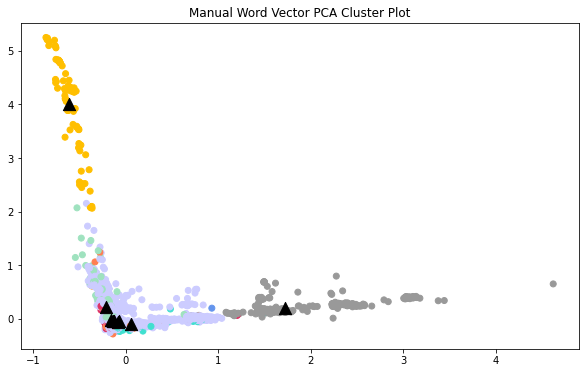

train adjusted_rand_score: -0.01014161438723638
test adjusted_rand_score: -0.011391351171441931


In [26]:
# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'Manual Word Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)

## TF-IDF

In [27]:
tfidf = TfidfVectorizer(ngram_range=ngram_range, min_df=5, max_df=0.95, max_features=8000)
XTrain = tfidf.fit_transform(X_train_data['text']).toarray()
XTest = tfidf.transform(X_test_data['text']).astype('float64').toarray()

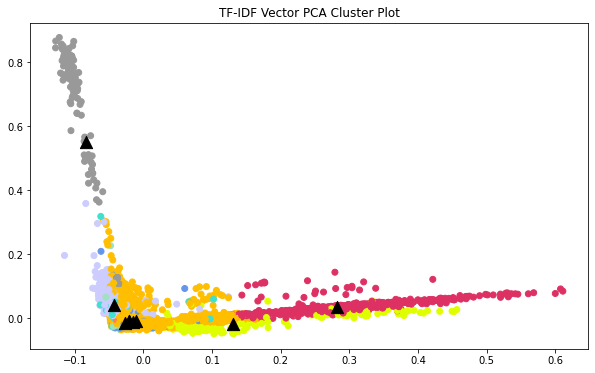

train adjusted_rand_score: 0.014794564050691126
test adjusted_rand_score: 0.01585312588234542


In [28]:
# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'TF-IDF Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)

## doc2vec Vector

In [29]:
doc2vec_corpus = list()
for doc in X_train_data['text']:
    c = Counter(doc.split())
    doc2vec_corpus.append(list(c))
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]

doc2vec_corpus_test = list()
for doc in X_test_data['text']:
    c = Counter(doc.split())
    doc2vec_corpus_test.append(list(c))
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]

epochs = 10   # How many epochs to be trained
vector_size = 500  # How many dimensions
alpha = .025   # Initial learning rate
min_alpha = .00025  # Learning rate changes step
dm = 1   # Use Distributed bags of words

doc2vec_model = Doc2Vec(vector_size=vector_size, window=10, min_count=1, workers=16, seed=111)
doc2vec_model.build_vocab(documents)

doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=15)
print('Finished model training process')

Finished model training process


In [30]:
X_test = list()
for doc in doc2vec_corpus_test:
    X_test.append(doc2vec_model.infer_vector(doc))
X_test = np.array(X_test)
X_test.shape

(4000, 500)

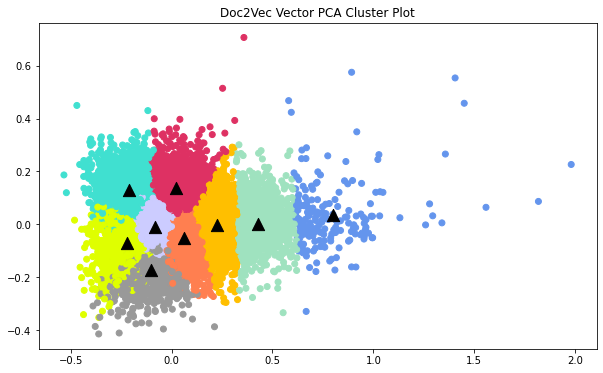

train adjusted_rand_score: 0.09941161215002865
test adjusted_rand_score: 0.13290984817784948


In [31]:
XTrain = doc2vec_model.docvecs.vectors_docs
XTest = X_test

# Perform K-means clustering
model, labels = get_kmeans(XTrain, y_train)
# Generate scatter plot of clusters
get_cluster_scatter_plot(XTrain, model, labels, 'Doc2Vec Vector')
# Evaluate performance with hamming loss
evaluate_cluster_performance(model, XTrain, y_train, XTest, y_test)